## Carga y formatting del CSV de los datos

In [ ]:
import cv2
import numpy
import pandas
import imageio.v3 as io
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from tensorflow.keras import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.optimizers import Adam

from typing import Optional, Union

In [ ]:
data = pandas.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vTvwmuQ-f2GebKR43ox55OIxy5qZxjc7bzmwYtAJSDfOQWRwON0wcyuPHZLlqkJDBLLF3h84krFVpKO/pub?gid=758289265&single=true&output=csv')
data.dropna(subset=["price"], inplace=True) # eliminar posibles datos no etiquetados
data.dropna(axis=1, how="all", inplace=True) # eliminar columnas vacías
data.head(5)

,id,listing_url,scrape_id,last_scraped,source,picture_url,host_id,host_url,host_name,host_since,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,3781,https://www.airbnb.com/rooms/3781,20231218233145,2023-12-19,city scrape,https://a0.muscache.com/pictures/24670/b2de044...,4804,https://www.airbnb.com/users/show/4804,Frank,2008-12-03,...,4.96,4.88,4.92,NaN,f,1,1,0,0,0.23
1,5506,https://www.airbnb.com/rooms/5506,20231218233145,2023-12-19,city scrape,https://a0.muscache.com/pictures/miso/Hosting-...,8229,https://www.airbnb.com/users/show/8229,Terry,2009-02-19,...,4.89,4.55,4.75,STR-490093,f,10,10,0,0,0.68
2,6695,https://www.airbnb.com/rooms/6695,20231218233145,2023-12-19,city scrape,https://a0.muscache.com/pictures/38ac4797-e7a4...,8229,https://www.airbnb.com/users/show/8229,Terry,2009-02-19,...,4.95,4.51,4.71,STR-491702,f,10,10,0,0,0.73
3,8789,https://www.airbnb.com/rooms/8789,20231218233145,2023-12-19,city scrape,https://a0.muscache.com/pictures/miso/Hosting-...,26988,https://www.airbnb.com/users/show/26988,Anne,2009-07-22,...,4.96,4.96,4.56,NaN,f,9,9,0,0,0.24
4,10813,https://www.airbnb.com/rooms/10813,20231218233145,2023-12-19,city scrape,https://a0.muscache.com/pictures/20b5b9c9-e1f4...,38997,https://www.airbnb.com/users/show/38997,Michelle,2009-09-16,...,5.00,5.00,4.80,NaN,f,11,11,0,0,0.09


In [ ]:
data.columns


Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source',
       'picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood', 'neighbourhood_cleansed', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'bathrooms_text', 'beds',
       'amenities', 'price', 'minimum_nights', 'maximum_nights',
       'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'calendar_l

In [ ]:
cols = [
    "host_response_rate",
    "host_acceptance_rate",
    "host_is_superhost",
    "host_listings_count",
    "host_has_profile_pic",
    "host_identity_verified",
    "neighbourhood_cleansed",
    "property_type",
    "accommodates",
    "beds",
    "number_of_reviews",
    "minimum_nights",
    "maximum_nights",
    "picture_url",
    "price"
]

data = data[cols]
data = data.dropna()
data.shape

(6449, 15)

In [ ]:
# Elimina el símbolo "$" y las comas de la columna 'price', luego convierte los valores a formato numérico
data['price'] = data['price'].str.replace('$', '').str.replace(',', '').astype(float)


In [ ]:
# Muestra las primeras filas del DataFrame después de la modificación
print(data['price'].head())

0    125.0
1    135.0
2    179.0
3     91.0
4     86.0
Name: price, dtype: float64


## Descarga de imágenes

In [ ]:
def download_images(paths: list,
                    canvas: tuple = (224, 224),
                    nb_channels: int = 3,
                    max_imgs: Optional[int] = None
                    ) -> tuple:
  """ Download a list of images from url adresses, converting them to a specific
  canvas size.

  Args:
    paths: Paths or url adresses from which to load images.
    canvas: Desired image width and height.
    nb_channels: Channels in images (1 for B/W, 3 for RGB).
    max_imgs: Upper threshold in the number of images to download.

  Return:
    a tuple of:
      - image values
      - indices within the paths that were successfull.

  """
  n_images = len(paths) if not max_imgs else max_imgs
  images = numpy.zeros((n_images, canvas[0], canvas[1], nb_channels),
                       dtype=numpy.uint8)
  downloaded_idxs = []

  for i_img, url in enumerate(tqdm(paths, total=n_images)):
    if i_img >= n_images:
      break
    try:
        img = io.imread(url)
        img = cv2.resize(img, (canvas[0], canvas[1]))
        downloaded_idxs.append(i_img)
        images[i_img] = img
    except:  # Unavailable url / conversion error
        pass
  return images[downloaded_idxs], downloaded_idxs

Normalización y conversión en el rango [0, 1]

In [ ]:
images, idxs = download_images(data['picture_url'])
images = images.astype("float32") / 255.
images.shape

100%|██████████| 6449/6449 [28:48<00:00,  3.73it/s]


(5717, 224, 224, 3)

Filtrado acorde en los demás datos

In [ ]:
# ¿De qué variables disponemos?
data.columns

Index(['host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_listings_count', 'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'property_type', 'accommodates', 'beds',
       'number_of_reviews', 'minimum_nights', 'maximum_nights', 'picture_url',
       'price'],
      dtype='object')

In [ ]:
filtered_data = data.iloc[idxs]
filtered_data

,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,property_type,accommodates,beds,number_of_reviews,minimum_nights,maximum_nights,picture_url,price
0,90%,29%,t,4,t,f,East Boston,Entire rental unit,2,1.0,24,29,1125,https://a0.muscache.com/pictures/24670/b2de044...,125.0
1,100%,100%,t,11,t,t,Roxbury,Entire guest suite,2,1.0,122,3,90,https://a0.muscache.com/pictures/miso/Hosting-...,135.0
2,100%,100%,t,11,t,t,Roxbury,Entire condo,4,2.0,127,3,730,https://a0.muscache.com/pictures/38ac4797-e7a4...,179.0
3,90%,50%,t,13,t,t,Beacon Hill,Entire rental unit,2,1.0,27,91,365,https://a0.muscache.com/pictures/miso/Hosting-...,91.0
4,98%,46%,f,19,t,t,Back Bay,Entire rental unit,2,1.0,5,32,1125,https://a0.muscache.com/pictures/20b5b9c9-e1f4...,86.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7194,100%,98%,f,81,t,t,Dorchester,Entire rental unit,5,3.0,1,1,365,https://a0.muscache.com/pictures/prohost-api/H...,83.0
7195,100%,98%,f,81,t,t,Downtown,Entire rental unit,6,3.0,0,1,365,https://a0.muscache.com/pictures/prohost-api/H...,107.0
7196,94%,100%,f,8,t,f,Fenway,Entire rental unit,3,2.0,0,1,365,https://a0.muscache.com/pictures/miso/Hosting-...,136.0
7197,100%,98%,f,81,t,t,Dorchester,Entire rental unit,5,3.0,0,1,365,https://a0.muscache.com/pictures/prohost-api/H...,83.0


Obtención de Embeddings

In [ ]:
base_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
last = base_resnet.layers[-1].output
x = GlobalAveragePooling2D()(last)
feature_extractor = Model(base_resnet.input, x)

In [ ]:
embeddings = []
preprocess = imagenet_utils.preprocess_input
for im in tqdm(images):
  input_im = preprocess(numpy.expand_dims(im, axis=0))
  embeddings.append(feature_extractor.predict(input_im, verbose=0))

embeddings = numpy.array(embeddings)

100%|██████████| 5717/5717 [26:21<00:00,  3.61it/s]


In [ ]:
filtered_data.reset_index(drop=True, inplace=True)
filtered_data.shape

(5717, 15)

## Guardado de los datos para posterior uso/selección

In [ ]:
numpy.save('images.npy', images)
filtered_data.to_csv('filtered_data.csv', sep=';', index=False)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp images.npy /content/drive/MyDrive/images_final.npy
!cp filtered_data.csv /content/drive/MyDrive/filtered_data.csv

!ls -lah images* filtered*  # Comprobación

-rw-r--r-- 1 root root 946K Jun 16 12:58 filtered_data.csv
-rw-r--r-- 1 root root 3.3G Jun 16 12:58 images.npy


In [ ]:
# Comprobamos a abrirlos de nuevo
data = pandas.read_csv("/content/drive/MyDrive/filtered_data.csv", sep=';')
imgs = numpy.load("/content/drive/MyDrive/images_final.npy")
data.shape, imgs.shape

((5717, 15), (5717, 224, 224, 3))

Así, por ejemplo, cargamos y visualizamos la distribución de las etiquetas:

0       125.0
1       135.0
2       179.0
3        91.0
4        86.0
        ...  
7079     83.0
7080    107.0
7081    136.0
7082     83.0
7083    106.0
Name: price, Length: 7084, dtype: float64


<Axes: >

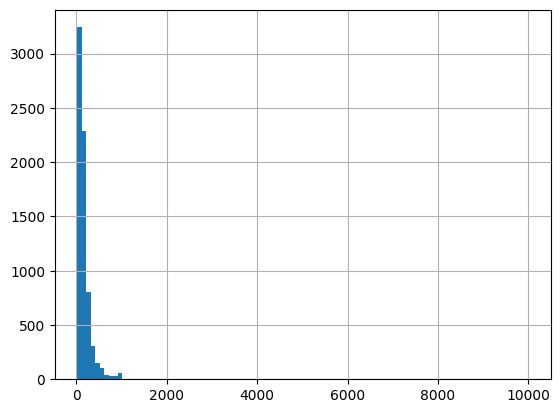

In [ ]:
print(data['price'])
data['price'].hist(bins=100)

Y podemos dividir por porcentajes, para crear clases, como por ejemplo:

In [ ]:
data['price'].describe()

count     7084.000000
mean       183.708498
std        304.138343
min         20.000000
25%         80.000000
50%        127.000000
75%        200.000000
max      10000.000000
Name: price, dtype: float64

<Axes: >

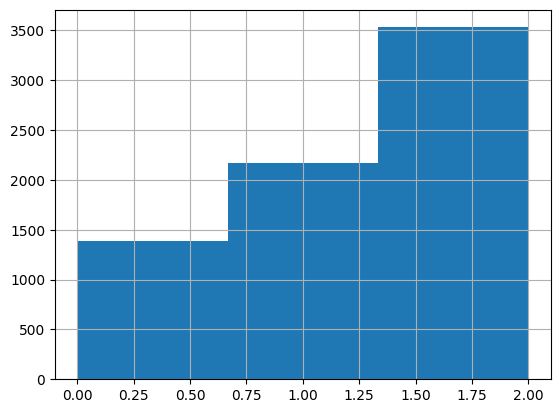

In [ ]:
y_class = []
for y in data['price']:
  if y <= 70:
    y_class.append(0) # Rango más barato
  elif 70 < y <= 127:
    y_class.append(1) # Rango intermedio
  else:
    y_class.append(2)
y_class = pandas.Series(y_class)
y_class.hist(bins=3)

## Dividiendo los datos y las imágenes en train y test

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

In [ ]:
train_df, test_df = train_test_split(
    data,
    test_size=0.3,
    random_state=42,
    shuffle=True
)
train_df, val_df = train_test_split(
    train_df,
    test_size=0.2,
    random_state=42,
    shuffle=True
)
print(f"Muestras en TRAIN ({len(train_df)}), VAL ({len(val_df)}), TEST ({len(test_df)})")

Muestras en TRAIN (3200), VAL (801), TEST (1716)


In [ ]:
train_idx = train_df.index
val_idx = val_df.index
test_idx = test_df.index

## Modelo 1D/tabular

### Preprocesado

In [ ]:
def pct_to_rate(x: str) -> float:
  return float(x.replace("%", "")) / 100 if isinstance(x, str) else x / 100

for df in [train_df, val_df, test_df]:
  df.loc[:, "host_response_rate"] = df["host_response_rate"].apply(pct_to_rate)
  df.loc[:, "host_acceptance_rate"] = df["host_acceptance_rate"].apply(pct_to_rate)

Normalización y categorización

In [ ]:
numerical_cols = [
    "host_response_rate",
    "host_acceptance_rate",
    "host_listings_count",
    "accommodates",
    "beds",
    "number_of_reviews",
    "minimum_nights",
    "maximum_nights"
]
categorical_cols = [
    "host_is_superhost",
    "host_has_profile_pic",
    "host_identity_verified",
    "neighbourhood_cleansed",
    "property_type"
]

In [ ]:
for numcol in numerical_cols:
  scaler = StandardScaler()
  scaler.fit(train_df[numcol].values.reshape(-1, 1))
  for df in [train_df, val_df, test_df]:
    df[numcol] = scaler.transform(df[numcol].values.reshape(-1, 1)).squeeze()

for catcol in categorical_cols:
  for df in [train_df, val_df, test_df]:
    df[catcol] = pandas.factorize(df[catcol])[0]

### Modelo 1D

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical

Asignación de clases

In [ ]:
quantiles = train_df["price"].quantile([0.33, 0.66]).values
print(f"Barato si menor que: {quantiles[0]}\nPromedio si menor que: {quantiles[1]}\nCaro si mayor que: {quantiles[1]}")

Barato si menor que: 88.0
Promedio si menor que: 160.0
Caro si mayor que: 160.0


In [ ]:
def assign_class(labels: pandas.Series, first_third: int, second_third: int) -> numpy.array:
  """ Assing one-hot encoding to  3 possible labels (price ranges). """
  y_cls = []
  for label in labels:
    if label <= first_third:
      y_cls.append(0)
    elif first_third < label <= second_third:
      y_cls.append(1)
    else:
      y_cls.append(2)
  return to_categorical(y_cls)

In [ ]:
train_y_cls = assign_class(train_df["price"], quantiles[0], quantiles[1])
val_y_cls = assign_class(val_df["price"], quantiles[0], quantiles[1])
test_y_cls = assign_class(test_df["price"], quantiles[0], quantiles[1])

Modelado

In [ ]:
def create_classifier(nb_inputs: int, nb_out: int, verbose: bool = True):
  model = Sequential()
  model.add(Dense(64, input_shape=(nb_inputs,), activation='relu'))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(8, activation='relu'))
  if nb_out > 1:
    model.add(Dense(nb_out, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  else:
    model.add(Dense(nb_out, activation="linear"))
    model.compile(loss='mean_squared_error', optimizer='adam')
  if verbose:
    model.summary()
  return model

In [ ]:
feature_cols = numerical_cols + categorical_cols
nb_inputs = len(feature_cols)
nb_outputs = train_y_cls.shape[1]

In [ ]:
model_1d_cls = create_classifier(nb_inputs, nb_outputs)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                896       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 8)                 264       
                                                                 
 dense_3 (Dense)             (None, 3)                 27        
                                                                 
Total params: 3267 (12.76 KB)
Trainable params: 3267 (12.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Entrenamiento del modelo

In [ ]:
MAX_EPOCHS = 100
BS = 128

H = model_1d_cls.fit(
    x=train_df[feature_cols].values,
    y=train_y_cls,
    batch_size=BS,
    epochs=MAX_EPOCHS,
    validation_data=(val_df[feature_cols].values, val_y_cls),
    callbacks=[EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=10, verbose=0, mode='auto')],
    shuffle=True,
    verbose=1
)

Epoch 1/100
25/25 [==============================] - 2s 15ms/step - loss: 1.0778 - accuracy: 0.4712 - val_loss: 1.0194 - val_accuracy: 0.5094
Epoch 2/100
25/25 [==============================] - 0s 5ms/step - loss: 0.9778 - accuracy: 0.5656 - val_loss: 0.9674 - val_accuracy: 0.5668
Epoch 3/100
25/25 [==============================] - 0s 4ms/step - loss: 0.9127 - accuracy: 0.5900 - val_loss: 0.9351 - val_accuracy: 0.5630
Epoch 4/100
25/25 [==============================] - 0s 5ms/step - loss: 0.8494 - accuracy: 0.6019 - val_loss: 0.9078 - val_accuracy: 0.5618
Epoch 5/100
25/25 [==============================] - 0s 5ms/step - loss: 0.8041 - accuracy: 0.6250 - val_loss: 0.8984 - val_accuracy: 0.5531
Epoch 6/100
25/25 [==============================] - 0s 5ms/step - loss: 0.7813 - accuracy: 0.6275 - val_loss: 0.8919 - val_accuracy: 0.5680
Epoch 7/100
25/25 [==============================] - 0s 6ms/step - loss: 0.7605 - accuracy: 0.6391 - val_loss: 0.8662 - val_accuracy: 0.5843
Epoch 8/100


[]

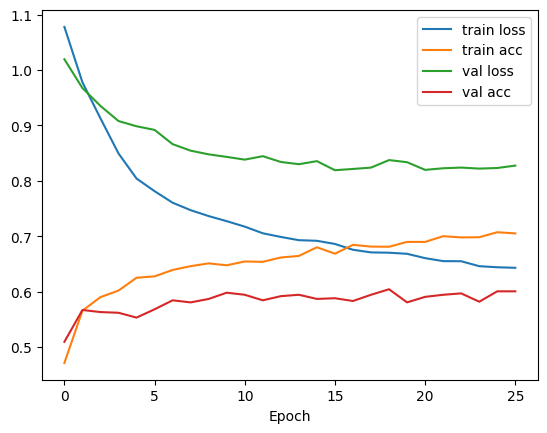

In [ ]:
plt.plot(H.history['loss'], label='train loss')
plt.plot(H.history['accuracy'], label='train acc')
plt.plot(H.history['val_loss'], label='val loss')
plt.plot(H.history['val_accuracy'], label='val acc')
plt.legend()
plt.xlabel('Epoch')
plt.plot()

Evaluación en test

In [ ]:
loss, acc = model_1d_cls.evaluate(test_df[feature_cols].values, test_y_cls)
print(f'Loss={loss:.3f}, Accuracy={acc:.3f} ')

54/54 [==============================] - 0s 4ms/step - loss: 0.9050 - accuracy: 0.5559
Loss=0.905, Accuracy=0.556 


## Modelo 2D/imágenes

In [ ]:
embeddings = embeddings.squeeze() #utilizamos los embedding obtenidos al principio del notebook con un modelo preentrenado.
nb_inputs = embeddings.shape[1]

In [ ]:
model_2d_cls = create_classifier(nb_inputs, nb_outputs)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                131136    
                                                                 
 dense_5 (Dense)             (None, 32)                2080      
                                                                 
 dense_6 (Dense)             (None, 8)                 264       
                                                                 
 dense_7 (Dense)             (None, 3)                 27        
                                                                 
Total params: 133507 (521.51 KB)
Trainable params: 133507 (521.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Entrenamiento

In [ ]:
H = model_2d_cls.fit(
    x=embeddings[train_df.index],
    y=train_y_cls,
    batch_size=BS,
    epochs=MAX_EPOCHS,
    validation_data=(embeddings[val_df.index], val_y_cls),
    callbacks=[EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, verbose=0, mode='auto')],
    shuffle=True,
    verbose=1
)

Epoch 1/100
25/25 [==============================] - 6s 67ms/step - loss: 1.1075 - accuracy: 0.3250 - val_loss: 1.0959 - val_accuracy: 0.3683
Epoch 2/100
25/25 [==============================] - 0s 18ms/step - loss: 1.0992 - accuracy: 0.3366 - val_loss: 1.0952 - val_accuracy: 0.3708
Epoch 3/100
25/25 [==============================] - 0s 11ms/step - loss: 1.1010 - accuracy: 0.3281 - val_loss: 1.0995 - val_accuracy: 0.2659
Epoch 4/100
25/25 [==============================] - 0s 8ms/step - loss: 1.0988 - accuracy: 0.3303 - val_loss: 1.0993 - val_accuracy: 0.3071
Epoch 5/100
25/25 [==============================] - 0s 8ms/step - loss: 1.0987 - accuracy: 0.3316 - val_loss: 1.0990 - val_accuracy: 0.3071
Epoch 6/100
25/25 [==============================] - 0s 10ms/step - loss: 1.0987 - accuracy: 0.3316 - val_loss: 1.0989 - val_accuracy: 0.3071
Epoch 7/100
25/25 [==============================] - 0s 8ms/step - loss: 1.0986 - accuracy: 0.3316 - val_loss: 1.0985 - val_accuracy: 0.3071
Epoch 8/1

[]

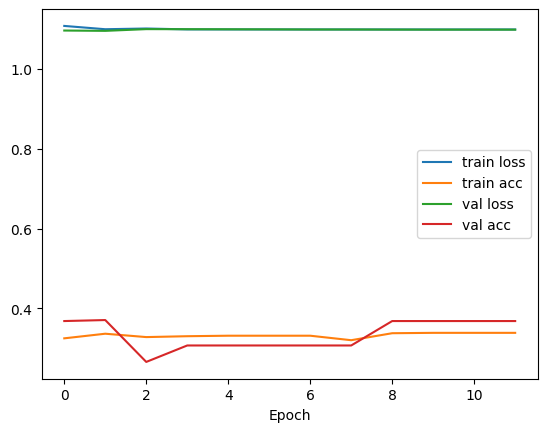

In [ ]:
plt.plot(H.history['loss'], label='train loss')
plt.plot(H.history['accuracy'], label='train acc')
plt.plot(H.history['val_loss'], label='val loss')
plt.plot(H.history['val_accuracy'], label='val acc')
plt.legend()
plt.xlabel('Epoch')
plt.plot()

Evaluación en test

In [ ]:
loss, acc = model_2d_cls.evaluate(embeddings[test_df.index], test_y_cls)
print(f'Loss={loss:.3f}, Accuracy={acc:.3f} ')

54/54 [==============================] - 0s 7ms/step - loss: 1.0989 - accuracy: 0.3217
Loss=1.099, Accuracy=0.322 


# LATE-FUSION

En este código se implementa una estrategia de **late-fusion**, donde se combinan las predicciones de dos modelos (un modelo 1D y un modelo 2D) para realizar una predicción final. A continuación, se detalla cada paso del proceso:

Primero, se obtienen las predicciones de los modelos 1D (`model_1d_cls`) y 2D (`model_2d_cls`) para los conjuntos de entrenamiento, validación y prueba.

In [ ]:
late_1d_train = model_1d_cls.predict(train_df[feature_cols].values)
late_1d_val = model_1d_cls.predict(val_df[feature_cols].values)
late_1d_test = model_1d_cls.predict(test_df[feature_cols].values)

late_2d_train = model_2d_cls.predict(embeddings[train_df.index])
late_2d_val = model_2d_cls.predict(embeddings[val_df.index])
late_2d_test = model_2d_cls.predict(embeddings[test_df.index])

54/54 [==============================] - 0s 2ms/step


Se combinan las predicciones de ambos modelos para crear nuevas características (`late_feats`) para cada conjunto (entrenamiento, validación y prueba).

In [ ]:
train_late_feats = numpy.concatenate([late_1d_train, late_2d_train], axis=1)
val_late_feats = numpy.concatenate([late_1d_val, late_2d_val], axis=1)
test_late_feats = numpy.concatenate([late_1d_test, late_2d_test], axis=1)

print(f"Dimensiones del nuevo conjunto de train: {train_late_feats.shape}")

Dimensiones del nuevo conjunto de train: (3200, 6)


Se crea un nuevo modelo de clasificación (`late_fuser`) que combinará las predicciones de los modelos 1D y 2D.

In [ ]:
late_fuser = create_classifier(train_late_feats.shape[1], train_y_cls.shape[1])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 64)                448       
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dense_10 (Dense)            (None, 8)                 264       
                                                                 
 dense_11 (Dense)            (None, 3)                 27        
                                                                 
Total params: 2819 (11.01 KB)
Trainable params: 2819 (11.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Se entrena el modelo de fusión utilizando las nuevas características de entrenamiento y validación, con un callback de `EarlyStopping` para evitar el sobreajuste.

In [ ]:
H = late_fuser.fit(
    x=train_late_feats,
    y=train_y_cls,
    batch_size=BS,
    epochs=MAX_EPOCHS,
    validation_data=(val_late_feats, val_y_cls),
    callbacks=[EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, verbose=0, mode='auto')],
    shuffle=True,
    verbose=1
)

Epoch 1/100
25/25 [==============================] - 1s 18ms/step - loss: 1.0598 - accuracy: 0.4053 - val_loss: 1.0260 - val_accuracy: 0.5144
Epoch 2/100
25/25 [==============================] - 0s 7ms/step - loss: 0.9731 - accuracy: 0.5628 - val_loss: 0.9574 - val_accuracy: 0.5243
Epoch 3/100
25/25 [==============================] - 0s 7ms/step - loss: 0.8899 - accuracy: 0.6069 - val_loss: 0.9044 - val_accuracy: 0.5481
Epoch 4/100
25/25 [==============================] - 0s 8ms/step - loss: 0.8153 - accuracy: 0.6478 - val_loss: 0.8614 - val_accuracy: 0.5830
Epoch 5/100
25/25 [==============================] - 0s 9ms/step - loss: 0.7454 - accuracy: 0.6766 - val_loss: 0.8350 - val_accuracy: 0.5693
Epoch 6/100
25/25 [==============================] - 0s 9ms/step - loss: 0.6923 - accuracy: 0.6919 - val_loss: 0.8242 - val_accuracy: 0.5905
Epoch 7/100
25/25 [==============================] - 0s 7ms/step - loss: 0.6652 - accuracy: 0.7025 - val_loss: 0.8255 - val_accuracy: 0.5868
Epoch 8/100


[]

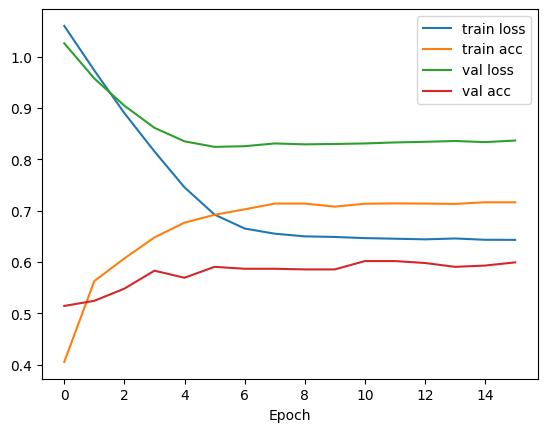

In [ ]:
plt.plot(H.history['loss'], label='train loss')
plt.plot(H.history['accuracy'], label='train acc')
plt.plot(H.history['val_loss'], label='val loss')
plt.plot(H.history['val_accuracy'], label='val acc')
plt.legend()
plt.xlabel('Epoch')
plt.plot()

Finalmente, se evalúa el rendimiento del modelo de fusión en el conjunto de prueba y se imprimen la pérdida (`loss`) y la precisión (`accuracy`).

In [ ]:
loss, acc = late_fuser.evaluate(test_late_feats, test_y_cls)
print(f'Loss={loss:.3f}, Accuracy={acc:.3f}')

54/54 [==============================] - 0s 3ms/step - loss: 0.9463 - accuracy: 0.5565
Loss=0.946, Accuracy=0.557


# EARLY-FUSION

ste código se implementa una estrategia de **early-fusion**, donde se combinan los embeddings obtenidos por un modelo 1D y un modelo 2D para realizar una predicción final. A continuación, se detalla cada paso del proceso:

Primero, se aplica PCA (Análisis de Componentes Principales) para reducir la dimensionalidad de los embeddings obtenidos del modelo 2D. Esto se hace para los conjuntos de entrenamiento, validación y prueba.

In [ ]:
pca = PCA(n_components=24, random_state=42)
train_early_pca = pca.fit_transform(embeddings[train_df.index])
val_early_pca = pca.transform(embeddings[val_df.index])
test_early_pca = pca.transform(embeddings[test_df.index])

In [ ]:
pca.explained_variance_ratio_.sum()

0.9142878

Se combinan las características originales de los datos con los componentes principales obtenidos de PCA para crear nuevas características (`early_feats`) para cada conjunto (entrenamiento, validación y prueba).

In [ ]:
train_early_feats = numpy.concatenate([train_df[feature_cols].values, train_early_pca], axis=1)
val_early_feats = numpy.concatenate([val_df[feature_cols].values, val_early_pca], axis=1)
test_early_feats = numpy.concatenate([test_df[feature_cols].values, test_early_pca], axis=1)

print(f"Dimensiones del nuevo conjunto de train: {train_early_feats.shape}")

Dimensiones del nuevo conjunto de train: (3200, 37)


Se crea un nuevo modelo de clasificación (`early_fuser`) que combinará las características originales y los componentes principales obtenidos de PCA. Y se entrena el modelo de fusión utilizando las nuevas características de entrenamiento y validación, con un callback de `EarlyStopping` para evitar el sobreajuste.

In [ ]:
early_fuser = create_classifier(train_early_feats.shape[1], train_y_cls.shape[1])

H = early_fuser.fit(
    x=train_early_feats,
    y=train_y_cls,
    batch_size=BS,
    epochs=MAX_EPOCHS,
    validation_data=(val_early_feats, val_y_cls),
    callbacks=[EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, verbose=0, mode='auto')],
    shuffle=True,
    verbose=1
)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 64)                2432      
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dense_14 (Dense)            (None, 8)                 264       
                                                                 
 dense_15 (Dense)            (None, 3)                 27        
                                                                 
Total params: 4803 (18.76 KB)
Trainable params: 4803 (18.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
25/25 [==============================] - 1s 12ms/step - loss: 1.1137 - accuracy: 0.4069 - val_loss: 1.0908 - val_accuracy: 0.3970
Epoch 2/10

[]

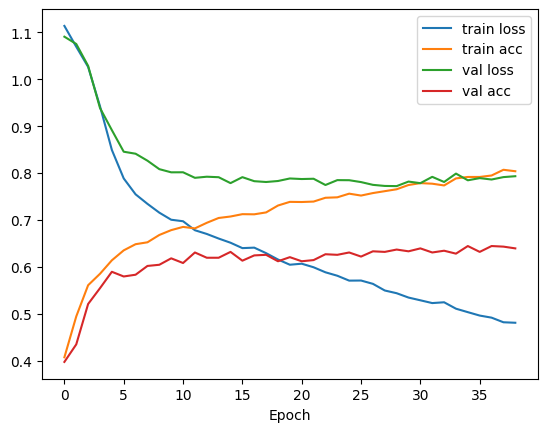

In [ ]:
plt.plot(H.history['loss'], label='train loss')
plt.plot(H.history['accuracy'], label='train acc')
plt.plot(H.history['val_loss'], label='val loss')
plt.plot(H.history['val_accuracy'], label='val acc')
plt.legend()
plt.xlabel('Epoch')
plt.plot()

Finalmente, se evalúa el rendimiento del modelo de fusión en el conjunto de prueba y se imprimen la pérdida (`loss`) y la precisión (`accuracy`).

In [ ]:
loss, acc = early_fuser.evaluate(test_early_feats, test_y_cls)
print(f'Loss={loss:.3f}, Accuracy={acc:.3f} ')

54/54 [==============================] - 0s 3ms/step - loss: 0.8663 - accuracy: 0.6055
Loss=0.866, Accuracy=0.605 


Aunque había completado hasta casi el ejercicio dos en la práctica, tuve que rehacerlo siguiendo tus pasos. Intenté combinar tu solución con la mía, pero encontré errores por todas partes. Sin embargo, al final logré entender todos los procesos realizados en la práctica, y así poder terminarla.